<h1>2024 São Paulo Crime Report: Data Analysis</h1> 

Author: <a href=https://www.linkedin.com/in/mailson-p-92909928a/> Mailson Vieira Passos <a/>

<hr>

<h2><span id='Objetivo'>Objective</span></h2>
<ul>
    <li>Data Analysis and model building</li>
</ul>

<hr>
<h2>About the data</h2>

The raw data can be found on <a href = "https://www.ssp.sp.gov.br/estatistica/consultas">SSP</a>. The data we will use is already cleaned (to an extent) and transformed.

<table>
    <thead>
        <tr>
            <th>Variable</th>
            <th>Description</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <th>natureza_apurada</th>
            <td>Classification of the crime</td>
        </tr>
        <tr>
            <th>mun_ocorr</th>
            <td>Municipality where the incident occurred. </td>
        </tr>
        <tr>
            <th>populacao</th>
            <td>Number of population. </td>
        </tr>
        <tr>
            <th>area_km2</th>
            <td>Area of the municipality in square kilometers. </td>
        </tr> 
         <tr>
            <th>pib_em_milhares</th>
            <td>The GDP (in thousands BRL) of each São Paulo municipality. </td>
        </tr> 
    </tbody>
</table>

<hr>
<h2>Requirements</h2>

```python
!pip install duckdb==1.1.2
!pip install pandas==2.0.0
!pip install numpy==1.26.1
!pip install seaborn==0.13.2
!pip install statsmodels==0.14.2
!pip install sklearn==1.4.1.post1  
```
<hr>

In [1]:
#data management libraries
import duckdb
import pandas as pd
#numberical libraries
import numpy as np
from scipy import stats
#visualization library
import matplotlib.pyplot as plt
import seaborn as sns
#typing libraries
import matplotlib.axes
from numpy.typing import ArrayLike
#modeling libraries
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

Let's read the data contained in DCSP.parquet

In [2]:
df = pd.read_parquet('data/DCSP.parquet')
df.head()

,natureza_apurada,mun_ocorr,populacao,area_km2,pib_em_milhares
0,ROUBO - OUTROS,São Paulo,11451999.0,1521.202,828980608.0
1,FURTO - OUTROS,São Paulo,11451999.0,1521.202,828980608.0
2,FURTO - OUTROS,São Paulo,11451999.0,1521.202,828980608.0
3,ROUBO - OUTROS,São Paulo,11451999.0,1521.202,828980608.0
4,ROUBO - OUTROS,São Paulo,11451999.0,1521.202,828980608.0


Since we have the populacao (population) and area_km2 columns, we can create a new column called densidade_populacional to store the population density of each municipality, as well as a pib_per_capita column to store each municipality's GDP per capita.

In [3]:
df['densidade_populacional'] = df['populacao'] / df['area_km2']
df['pib_per_capita'] = df['pib_em_milhares'] * 1e3 / df['populacao']

We will use DuckDB to perform some analysis on the data because, given the nature of the data, it is much more convenient than using pandas.

In [4]:
con = duckdb.connect()

Let's compare the number of ocurrences per 10000 habitants for each municipality.

In [5]:
con.sql(f'''
    WITH dados_agrupados AS (
        SELECT mun_ocorr, count(mun_ocorr) AS quant,  populacao
        FROM df
        WHERE mun_ocorr <> 'NULL'
        GROUP BY ALL
    )
    SELECT mun_ocorr, (quant / populacao) * 1e4 AS ocorr_por_10Khab 
    FROM dados_agrupados
    ORDER BY ocorr_por_10Khab desc;
    '''
).df().set_index('mun_ocorr')

,ocorr_por_10Khab
mun_ocorr,
Ipuã,319.634703
Mongaguá,315.249149
São Paulo,310.020984
Jeriquara,256.277505
Praia Grande,246.474345
...,...
Alto Alegre,18.224421
Itaoca,17.533606
Inúbia Paulista,16.597510


The municipality of Ipuã, which is a small town in the northern part of the State of São Paulo, has more occurrences than the capital, São Paulo, which is one of the largest city in the world by area and population.

Now we do the same but we add the nature of the crime, that is, if it was theft or robbery.

In [6]:
con.sql(f'''
    WITH dados_agrupados AS (
        SELECT natureza_apurada, count(natureza_apurada) as quant, mun_ocorr, populacao
        FROM df
        WHERE mun_ocorr <> 'NULL'
        GROUP BY ALL
    )
    SELECT mun_ocorr, natureza_apurada, quant / populacao * 1e4 as ocorr_por_10Khab 
    FROM dados_agrupados
    ORDER BY ocorr_por_10Khab desc;
    '''
).df().set_index(['mun_ocorr', 'natureza_apurada'])

ocorr_por_10Khab
mun_ocorr    natureza_apurada                                           
Mongaguá     FURTO - OUTROS                                   163.839163
Jeriquara    PORTE DE ENTORPECENTES                           163.085685
São Paulo    FURTO - OUTROS                                   154.745909
Ipuã         PORTE DE ENTORPECENTES                           143.212951
Praia Grande FURTO - OUTROS                                   132.424593
...                                                                  ...
São Paulo    HOMICÍDIO DOLOSO POR ACIDENTE DE TRÂNSITO          0.007859
Guarulhos    LESÃO CORPORAL SEGUIDA DE MORTE                    0.007741
             HOMICÍDIO DOLOSO POR ACIDENTE DE TRÂNSITO          0.007741
São Paulo    HOMICÍDIO CULPOSO OUTROS                           0.006986
             ROUBO A BANCO                                      0.000873

[6940 rows x 1 columns]

If we distinguish by nature, we see that the capital, São Paulo, is still not at the top. The most ocurrence per 10000 inhabitants is in the coastal city of Mongaguá, where theft is most common, closely followed by possession of narcotics in the northern city of Jeriquara. The capital (the largest city of Brazil) only ranks third, with theft.

Let's build a model

## Modeling

To build the model, we will choose the number of robberies as the outcome variable.  To do this we are going to count the occurences and filter out 'NULL' values, and ensure that the nature of the crime is 'ROUBO - OUTROS' (robbery).

In [7]:
mod_df = con.sql(f'''
    WITH count_per_mun AS (
        SELECT mun_ocorr, count(mun_ocorr) as ocorr_roubo
        FROM df
        WHERE mun_ocorr <> 'NULL' 
        GROUP BY ALL
    )
    SELECT D.*, C.* EXCLUDE mun_ocorr
    FROM df AS D
    LEFT JOIN count_per_mun AS C
    ON C.mun_ocorr = D.mun_ocorr
    WHERE natureza_apurada ='ROUBO - OUTROS'
    '''
).df()
mod_df.head()

,natureza_apurada,mun_ocorr,populacao,area_km2,pib_em_milhares,densidade_populacional,pib_per_capita,ocorr_roubo
0,ROUBO - OUTROS,Embu-Guaçu,66970.0,155.641,1456125.0,430.285079,21742.944602,642
1,ROUBO - OUTROS,Embu-Guaçu,66970.0,155.641,1456125.0,430.285079,21742.944602,642
2,ROUBO - OUTROS,Embu-Guaçu,66970.0,155.641,1456125.0,430.285079,21742.944602,642
3,ROUBO - OUTROS,Embu-Guaçu,66970.0,155.641,1456125.0,430.285079,21742.944602,642
4,ROUBO - OUTROS,São Paulo,11451999.0,1521.202,828980608.0,7528.256602,72387.415332,355036


We have retrieved a DataFrame and named it 'mod_df.' We will group the data by municipality and get the last values for each group.

In [8]:
mod_df = mod_df.groupby('mun_ocorr').last()

Let's analyse the distribution

<Axes: xlabel='ocorr_roubo', ylabel='Count'>

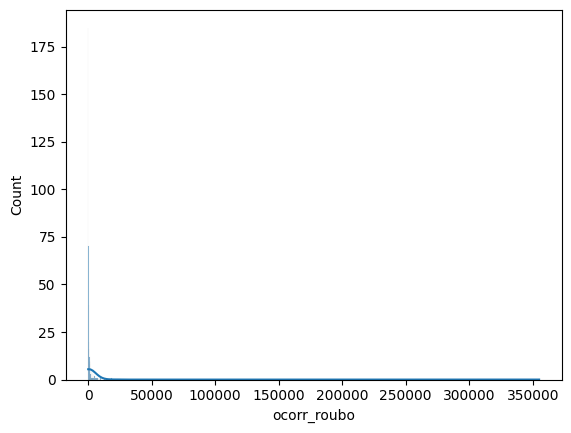

In [9]:
sns.histplot(mod_df['ocorr_roubo'], kde = True)

We can't see much. There is clearly one value that stands out from the others, which is undoubtedly the capital (São Paulo). Let's do a log transformation.

<Axes: xlabel='ocorr_roubo', ylabel='Count'>

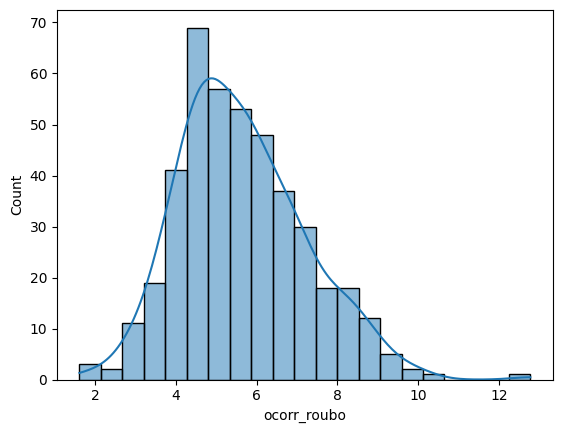

In [10]:
sns.histplot(np.log(mod_df['ocorr_roubo']), kde = True)

We can now see the distribution. It is right-skewed. We can try comparing the outcome with each possible predictor to assess any possible relation. Before doing that we will create a new column called 'log_ocorr_roubo', which is, the log transformation of the number of occurrences of robbery.

In [11]:
mod_df['log_ocorr_roubo'] = np.log(mod_df['ocorr_roubo'])

We can try a log-log plot

<Axes: xlabel='populacao', ylabel='log_ocorr_roubo'>

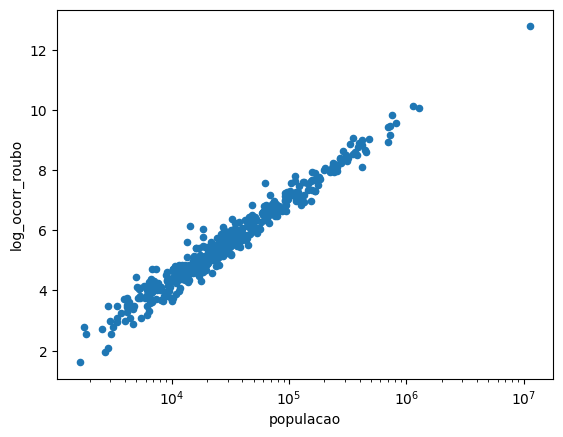

In [12]:
mod_df.plot(kind = 'scatter', y = 'log_ocorr_roubo', x = 'populacao', logx = True)

There seems to be a strong linear association.

In [13]:
def plot_scatter(
    x: ArrayLike, 
    y: ArrayLike, 
    xlabel: str | None = None,
    ylabel: str | None = None,
    ax: matplotlib.axes.Axes | None = None, 
    reg : bool | None = None, 
    order: int | None = None, 
    show: bool | None = None
) -> matplotlib.axes.Axes:
    '''Plota um gráfico de dispersão com valor de correlação

    Parametros
    ---
    x: np.array
        X
    y: np.array
        Y
    reg: bool, optional
        Plota regressão
    order: bool, optional
        Ordem da regressão
    '''
    if not ax:
        fig, ax = plt.subplots()

    if reg:
        if order is None:
            order = 1
        sns.regplot(x = x, y = y, order = order, ax = ax, line_kws={"color": "C1"})
    else:
        ax.scatter(x, y)

    data_vals = pd.DataFrame(np.c_[x, y], columns = ['x', 'y']).dropna()
    corr, pval = stats.pearsonr(data_vals['x'], data_vals['y'])
    
    ax.set_title('corr = {:.2f}  pval = {:.2e}'.format(corr, pval))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax

<Axes: title={'center': 'corr = 0.98  pval = 1.75e-307'}, xlabel='log_ocorr_roubo', ylabel='populacao'>

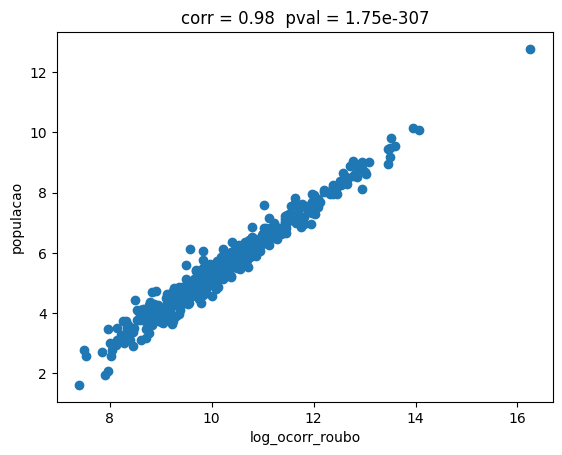

In [14]:
plot_scatter(np.log(mod_df['populacao']), mod_df['log_ocorr_roubo'], 'log_ocorr_roubo', 'populacao')

The correlation is really high. We will do the same for each possible predictors.

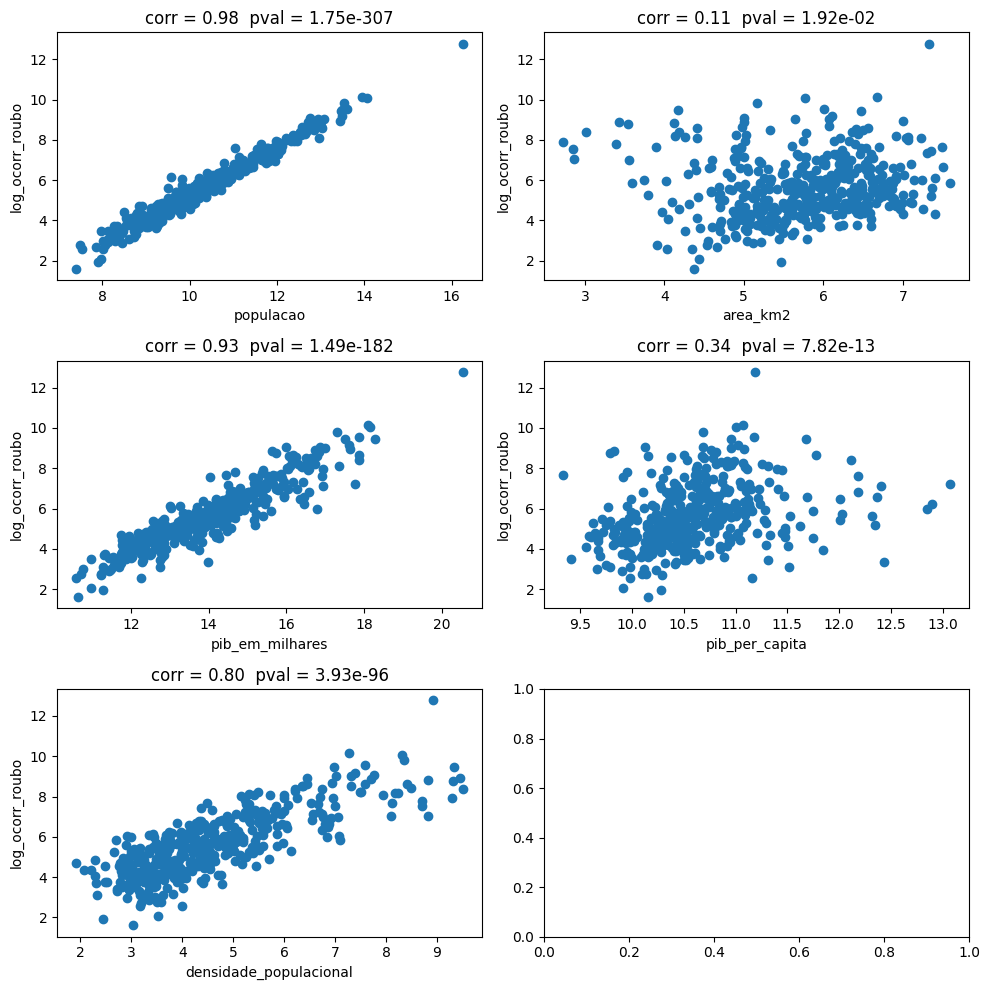

In [15]:
cols = ['populacao', 'area_km2', 'pib_em_milhares', 'pib_per_capita', 'densidade_populacional']
fig, axs = plt.subplots(int(np.ceil(len(cols)/2)), 2, figsize = (10,10))
for ax, col in zip(axs.ravel(), cols):
    plot_scatter(
        np.log(mod_df[col]), 
        mod_df['log_ocorr_roubo'], 
        xlabel = col, 
        ylabel = 'log_ocorr_roubo', 
        ax = ax
)
fig.tight_layout()
plt.show()

We can see that there's no correlation between log_ocorr_roubo with area_km2 and weak correlation with pib_per_capita.

Now, we are going to perform feature importance using Random Forest

In [16]:
possible_preds = cols

In [17]:
def rank_feature_importance(
    X : pd.DataFrame, 
    y : ArrayLike, 
    num_tree : int, 
    n_repeats : int, 
    random_state : int | None = None,
) -> pd.DataFrame:
    '''Ranks features by importance scores using Random Forests'''
    
    clf = RandomForestClassifier(n_estimators=num_tree, random_state=random_state)\
        .fit(X, y)
    result = permutation_importance(
        clf,
        X, 
        y, 
        n_repeats=n_repeats, 
        n_jobs = 1,
        random_state=random_state
    )
    res = pd.DataFrame({
        "Feature": X.columns,
        "Importance Mean": result["importances_mean"],
        "Importance Std": result["importances_std"]
    }).sort_values("Importance Mean", ascending=False)

    return res

In [18]:
possible_pred = rank_feature_importance(
    mod_df[possible_preds],
    mod_df['ocorr_roubo'],
    num_tree = 200,
    n_repeats = 50, 
)
possible_pred

,Feature,Importance Mean,Importance Std
0,populacao,0.250351,0.017019
2,pib_em_milhares,0.088899,0.011672
3,pib_per_capita,0.062389,0.009721
1,area_km2,0.026979,0.007785
4,densidade_populacional,0.020562,0.006695


Notice that populacao (population) is the most important feature, followed by the feature pib_em_milhares (GDP in thousands BRL). These results suggest that we should keep only populacao and pib_em_milhares, as the other variables - with the exception of area_km2 - are correlated with the ones that I chose. Because area_km2 is not correlated and has a low feature importance score, we are not keeping it.

Let's check if populacao and pib_per_capita are correlated.

<Axes: title={'center': 'corr = 0.34  pval = 7.82e-13'}>

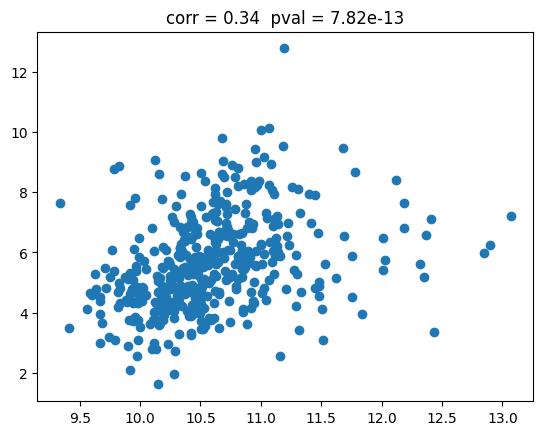

In [19]:
plot_scatter(
    np.log(mod_df['pib_per_capita']), 
    mod_df['log_ocorr_roubo'], 
)

In [20]:
print('VIF = ', 1/(1-0.34**2))

VIF =  1.1307100859339665


We have no multicolinearity.

In [21]:
X = np.log(mod_df[['populacao', 'pib_per_capita']])
X = sm.add_constant(X)
y = mod_df['log_ocorr_roubo']

In [22]:
ols_model = sm.OLS(
    y.astype(float), 
    X
).fit()

In [23]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_ocorr_roubo   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     5586.
Date:                Mon, 12 May 2025   Prob (F-statistic):          2.31e-305
Time:                        00:25:02   Log-Likelihood:                -93.477
No. Observations:                 427   AIC:                             193.0
Df Residuals:                     424   BIC:                             205.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -6.4535      0.277    -23.268      0.000      -6.999      -5.908
populacao          1.1751      0.012     99.256      0.000       1.152       1.198
pib_per_capita    -0.0026      0.028     -0.092      0.926      -0.057       0.052
==============================================================================
Omnibus:                       23.680   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.926
Skew:                           0.367   Prob(JB):                     1.30e-09
Kurtosis:                       4.328   Cond. No.                         283.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We observed that pip_per_capita did not contribute significantly to the model. I also checked the adjusted R-squared and decided to not keep this variable.

In [24]:
X = np.log(mod_df[['populacao']])
X = sm.add_constant(X)
y = mod_df['log_ocorr_roubo']

ols_model = sm.OLS(
    y.astype(float), 
    X
).fit()
lm_resid = ols_model.resid
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_ocorr_roubo   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                 1.120e+04
Date:                Mon, 12 May 2025   Prob (F-statistic):          1.75e-307
Time:                        00:25:02   Log-Likelihood:                -93.481
No. Observations:                 427   AIC:                             191.0
Df Residuals:                     425   BIC:                             199.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.4768      0.115    -56.110      0.000      -6.704      -6.250
populacao      1.1747      0.011    105.824      0.000       1.153       1.197
==============================================================================
Omnibus:                       23.780   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.104
Skew:                           0.368   Prob(JB):                     1.19e-09
Kurtosis:                       4.330   Cond. No.                         82.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
def regression_diagnostics(fit: ArrayLike, resid: ArrayLike):
    fig, axs = plt.subplots(2, 2, figsize = (8, 6))

    sns.scatterplot(x = fit, y = resid, ax = axs[0,0])
    axs[0,0].plot(fit, [0] * len(fit), 'k--')
    axs[0,0].set_xlabel("Fitted values")
    axs[0,0].set_ylabel("Residuals")

    sm.qqplot(lm_resid, fit = True,  line='45', ax = axs[0,1])

    sns.scatterplot(x = fit, y = np.abs(resid), ax = axs[1,0])
    axs[1,0].set_xlabel("Fitted values")
    axs[1,0].set_ylabel("Absolute Residuals")

    sns.scatterplot(x = fit, y = resid/np.std(resid), ax = axs[1,1])
    axs[1,1].set_xlabel("Fitted values")
    axs[1,1].set_ylabel("Standardized Residuals")
    
    fig.tight_layout()
    plt.show()

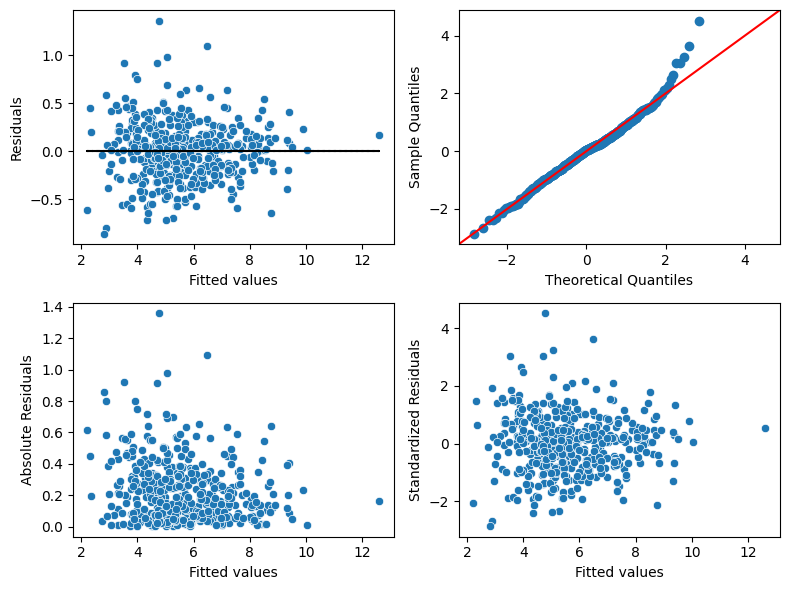

In [26]:
regression_diagnostics(ols_model.fittedvalues, lm_resid)

From the diagnostics, we observe a slight departure from normality in the right tail, although the distribution remains approximately normal. We also notice that the variance is not constant, but the deviation is not too severe overall.  

Let's interpret the results: a 1% increase in population number results into an approximately 1.17% increase in the number of reported occurrences of robbery.